# Results: Visualizations and Paper-Ready Tables — MovieLens 1M

This notebook generates:
- Score distribution plots (per model and ensemble)
- Feature vs anomaly score plots (interpretability)
- Paper-ready tables (Top suspicious users, thresholds, agreement)
- Optional qualitative case study (raw ratings for selected users)

Inputs:
- movielens1m_user_features.csv
- movielens1m_unsupervised_scores.csv

Outputs (saved under ./results/):
- PNG figures
- CSV tables


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = os.getcwd()
FEATURES_PATH = os.path.join(ROOT, "movielens1m_user_features.csv")
SCORES_PATH   = os.path.join(ROOT, "movielens1m_unsupervised_scores.csv")

RESULTS_DIR = os.path.join(ROOT, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

pd.set_option("display.max_columns", 200)


Load + merge

In [2]:
features = pd.read_csv(FEATURES_PATH)
scores   = pd.read_csv(SCORES_PATH)

df = scores.merge(features, on="user_id", how="left")

print("features:", features.shape)
print("scores  :", scores.shape)
print("merged  :", df.shape)

df.head()


features: (6040, 21)
scores  : (6040, 8)
merged  : (6040, 28)


,user_id,iso_score,svm_score,ae_score,iso_score_n,svm_score_n,ae_score_n,ensemble_score,num_ratings,mean_rating,std_rating,min_rating,max_rating,entropy_rating,ratio_1,ratio_5,extreme_ratio,mean_abs_dev,delta_mean_s,delta_std_s,profile_span_s,ratings_per_day,burst_ratio_10min,index,mean_item_pop,std_item_pop,min_item_pop,max_item_pop
0,4486,0.673695,1.648691,0.594374,1.000000,1.000000,1.000000,1.000000,36,1.083333,0.363242,1.0,3.0,0.365099,0.944444,0.000000,0.944444,0.157407,5.057143e+00,1.045519e+01,177.0,17572.881356,0.972222,4485,513.416667,787.707940,23,2883
1,3598,0.616883,1.648691,0.457052,0.819323,1.000000,0.768188,0.862504,60,1.016667,0.128019,1.0,2.0,0.122292,0.983333,0.000000,0.983333,0.032778,1.479661e+01,3.029280e+01,873.0,5938.144330,0.983333,3597,719.083333,788.694941,28,2990
2,4463,0.604229,1.179753,0.427355,0.779080,0.868980,0.718057,0.788706,20,3.950000,0.920598,2.0,5.0,1.782229,0.000000,0.300000,0.300000,0.675000,3.487618e+06,1.479639e+07,66264734.0,0.026077,0.900000,4462,945.000000,807.482260,66,2653
3,46,0.598529,1.011191,0.399165,0.760954,0.821884,0.670470,0.751103,38,4.368421,1.458569,1.0,5.0,0.629249,0.157895,0.842105,1.000000,1.063712,1.724324e+01,3.133895e+01,638.0,5146.081505,0.973684,45,382.342105,416.077250,26,2250
4,164,0.668234,0.657408,0.307285,0.982632,0.723038,0.515367,0.740346,26,4.384615,0.624926,3.0,5.0,1.314320,0.000000,0.461538,0.461538,0.568047,2.145513e+06,8.082084e+06,53637824.0,0.041881,0.846154,163,739.000000,655.382918,63,2269


1) Score distributions

In [3]:
def save_fig(filename: str):
    path = os.path.join(RESULTS_DIR, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    print("Saved figure:", path)


Histogram: ensemble score

Saved figure: C:\Users\USUARIO\Desktop\app\results\fig_ensemble_score_distribution.png


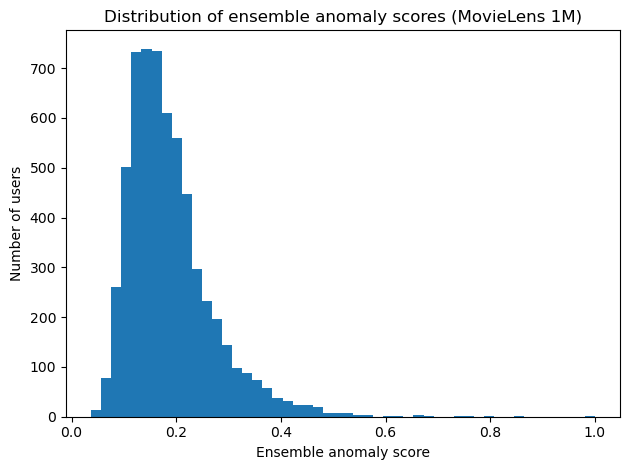

In [4]:
plt.figure()
plt.hist(df["ensemble_score"].values, bins=50)
plt.xlabel("Ensemble anomaly score")
plt.ylabel("Number of users")
plt.title("Distribution of ensemble anomaly scores (MovieLens 1M)")
save_fig("fig_ensemble_score_distribution.png")
plt.show()


Histogram: model-wise normalized scores

Saved figure: C:\Users\USUARIO\Desktop\app\results\fig_iso_score_n_distribution.png


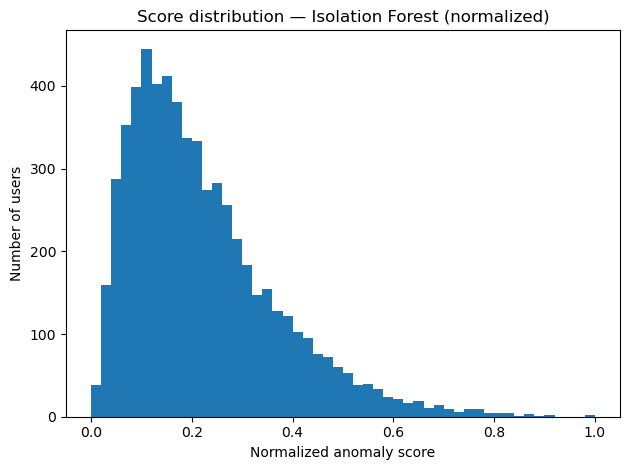

Saved figure: C:\Users\USUARIO\Desktop\app\results\fig_svm_score_n_distribution.png


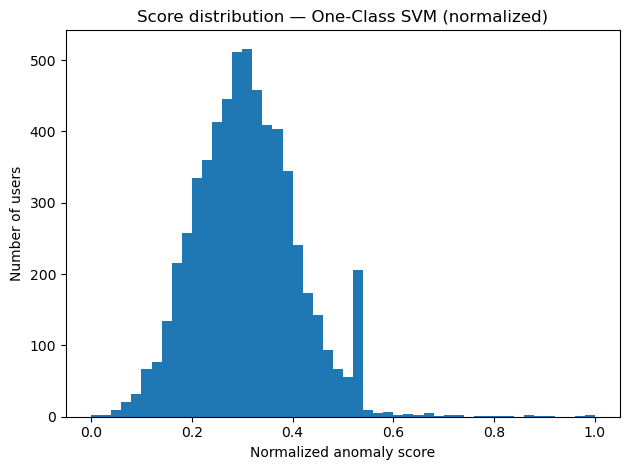

Saved figure: C:\Users\USUARIO\Desktop\app\results\fig_ae_score_n_distribution.png


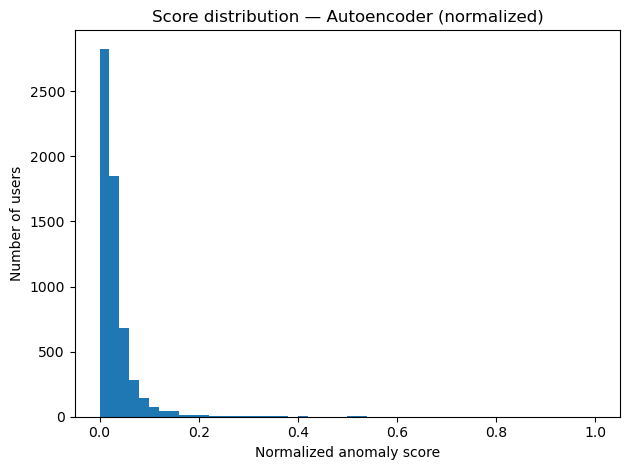

In [5]:
for col, title in [
    ("iso_score_n", "Isolation Forest (normalized)"),
    ("svm_score_n", "One-Class SVM (normalized)"),
    ("ae_score_n",  "Autoencoder (normalized)"),
]:
    plt.figure()
    plt.hist(df[col].values, bins=50)
    plt.xlabel("Normalized anomaly score")
    plt.ylabel("Number of users")
    plt.title(f"Score distribution — {title}")
    save_fig(f"fig_{col}_distribution.png")
    plt.show()


### 2) Threshold visualization (Top-p%)
Visualize thresholds for p = 1%, 2%, 5%

Saved figure: C:\Users\USUARIO\Desktop\app\results\fig_ensemble_thresholds_top_p.png


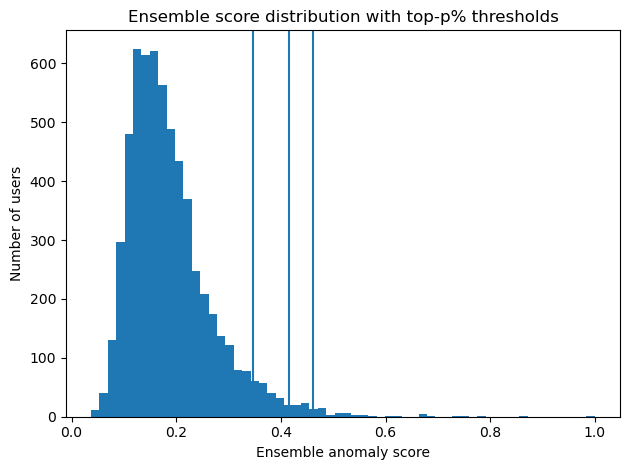

{1: 0.46168846169987127, 2: 0.4149335209800765, 5: 0.3476941867171099}

In [6]:
def threshold_for_top_percent(values: np.ndarray, p: float) -> float:
    return float(np.percentile(values, 100 - p))

ps = [1, 2, 5]
vals = df["ensemble_score"].values
thrs = {p: threshold_for_top_percent(vals, p) for p in ps}

plt.figure()
plt.hist(vals, bins=60)
for p in ps:
    plt.axvline(thrs[p])
plt.xlabel("Ensemble anomaly score")
plt.ylabel("Number of users")
plt.title("Ensemble score distribution with top-p% thresholds")
save_fig("fig_ensemble_thresholds_top_p.png")
plt.show()

thrs


### 3) Interpretability: features vs anomaly score
Scatter: num_ratings vs ensemble_score

Saved figure: C:\Users\USUARIO\Desktop\app\results\fig_num_ratings_vs_ensemble_score.png


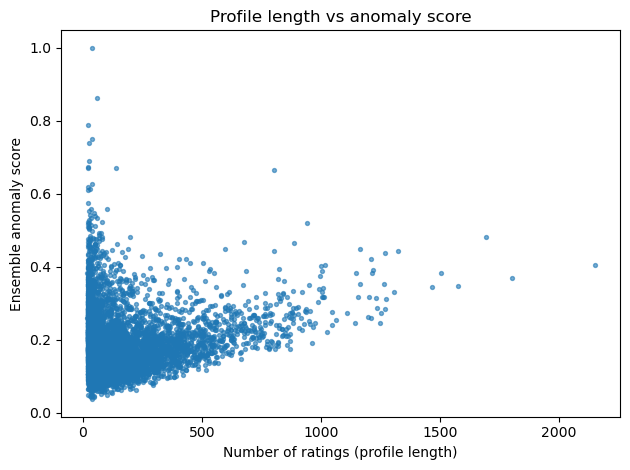

In [7]:
plt.figure()
plt.scatter(df["num_ratings"].values, df["ensemble_score"].values, s=8, alpha=0.6)
plt.xlabel("Number of ratings (profile length)")
plt.ylabel("Ensemble anomaly score")
plt.title("Profile length vs anomaly score")
save_fig("fig_num_ratings_vs_ensemble_score.png")
plt.show()


Scatter: extreme_ratio vs ensemble_score

Saved figure: C:\Users\USUARIO\Desktop\app\results\fig_extreme_ratio_vs_ensemble_score.png


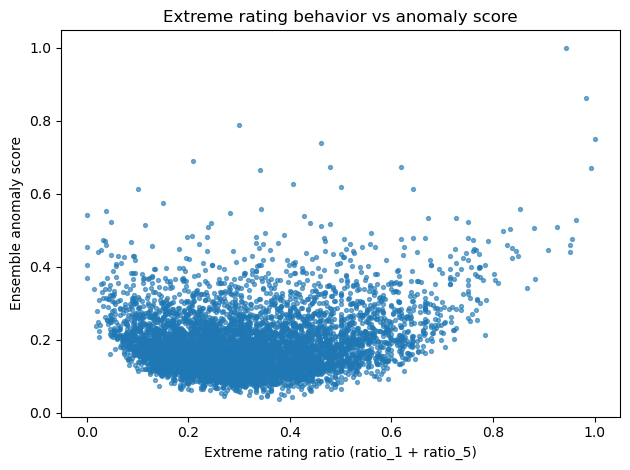

In [8]:
plt.figure()
plt.scatter(df["extreme_ratio"].values, df["ensemble_score"].values, s=8, alpha=0.6)
plt.xlabel("Extreme rating ratio (ratio_1 + ratio_5)")
plt.ylabel("Ensemble anomaly score")
plt.title("Extreme rating behavior vs anomaly score")
save_fig("fig_extreme_ratio_vs_ensemble_score.png")
plt.show()


Scatter: burst_ratio_10min vs ensemble_score

Saved figure: C:\Users\USUARIO\Desktop\app\results\fig_burst_ratio_vs_ensemble_score.png


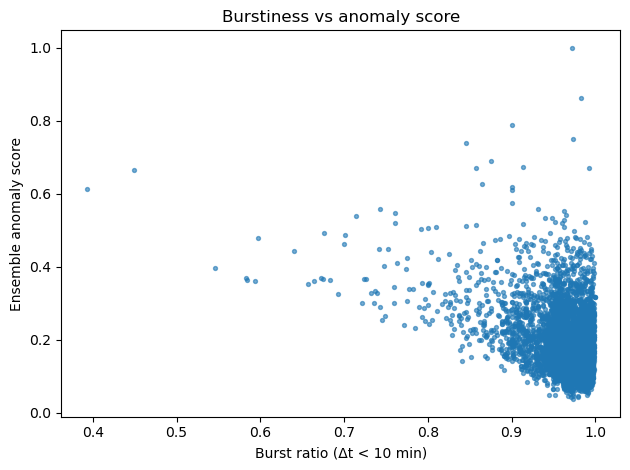

In [9]:
plt.figure()
plt.scatter(df["burst_ratio_10min"].values, df["ensemble_score"].values, s=8, alpha=0.6)
plt.xlabel("Burst ratio (Δt < 10 min)")
plt.ylabel("Ensemble anomaly score")
plt.title("Burstiness vs anomaly score")
save_fig("fig_burst_ratio_vs_ensemble_score.png")
plt.show()


Scatter: ratings_per_day vs ensemble_score

Saved figure: C:\Users\USUARIO\Desktop\app\results\fig_ratings_per_day_vs_ensemble_score.png


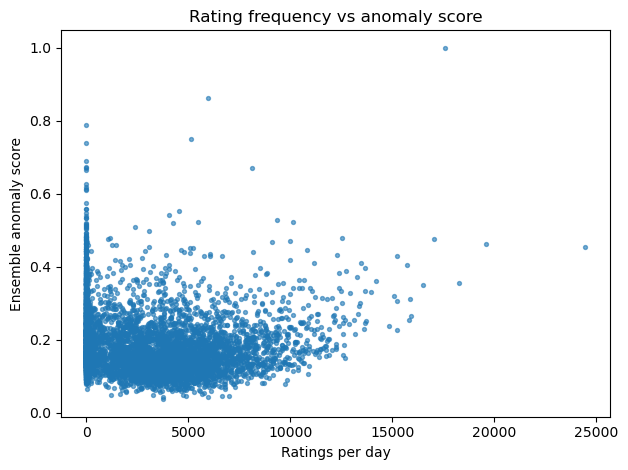

In [10]:
plt.figure()
plt.scatter(df["ratings_per_day"].values, df["ensemble_score"].values, s=8, alpha=0.6)
plt.xlabel("Ratings per day")
plt.ylabel("Ensemble anomaly score")
plt.title("Rating frequency vs anomaly score")
save_fig("fig_ratings_per_day_vs_ensemble_score.png")
plt.show()


### 4) Paper-ready tables
Threshold table (Top 1/2/5%)

In [11]:
def threshold_table(df: pd.DataFrame, score_col: str, ps=(1,2,5)) -> pd.DataFrame:
    rows = []
    n = len(df)
    for p in ps:
        thr = float(np.percentile(df[score_col].values, 100 - p))
        rows.append({
            "score_col": score_col,
            "top_percent": p,
            "threshold": thr,
            "flagged_users": int(np.ceil(n * (p/100.0)))
        })
    return pd.DataFrame(rows)

paper_thresholds = threshold_table(df, "ensemble_score", ps=(1,2,5))
paper_thresholds


,score_col,top_percent,threshold,flagged_users
0,ensemble_score,1,0.461688,61
1,ensemble_score,2,0.414934,121
2,ensemble_score,5,0.347694,302


Top suspicious users table (Top-N at p=2%)

In [12]:
P = 2
N = 30

thr = float(np.percentile(df["ensemble_score"].values, 100 - P))
top_df = df[df["ensemble_score"] >= thr].copy()
top_df = top_df.sort_values("ensemble_score", ascending=False).head(N)

cols = [
    "user_id",
    "ensemble_score",
    "iso_score_n", "svm_score_n", "ae_score_n",
    "num_ratings", "mean_rating", "std_rating",
    "extreme_ratio", "burst_ratio_10min", "ratings_per_day",
    "mean_item_pop", "std_item_pop"
]

paper_top = top_df[cols].reset_index(drop=True)
paper_top


,user_id,ensemble_score,iso_score_n,svm_score_n,ae_score_n,num_ratings,mean_rating,std_rating,extreme_ratio,burst_ratio_10min,ratings_per_day,mean_item_pop,std_item_pop
0,4486,1.000000,1.000000,1.000000,1.000000,36,1.083333,0.363242,0.944444,0.972222,17572.881356,513.416667,787.707940
1,3598,0.862504,0.819323,1.000000,0.768188,60,1.016667,0.128019,0.983333,0.983333,5938.144330,719.083333,788.694941
2,4463,0.788706,0.779080,0.868980,0.718057,20,3.950000,0.920598,0.300000,0.900000,0.026077,945.000000,807.482260
3,46,0.751103,0.760954,0.821884,0.670470,38,4.368421,1.458569,1.000000,0.973684,5146.081505,382.342105,416.077250
4,164,0.740346,0.982632,0.723038,0.515367,26,4.384615,0.624926,0.461538,0.846154,0.041881,739.000000,655.382918
5,5635,0.689863,0.781946,0.871207,0.416437,24,3.583333,0.953794,0.208333,0.875000,0.024522,889.625000,751.751167
6,5411,0.673361,0.873057,0.802114,0.344913,23,2.826087,1.493527,0.478261,0.913043,0.045813,749.739130,767.378554
7,89,0.672197,0.836250,0.765165,0.415177,21,3.238095,1.659167,0.619048,0.857143,0.111451,1082.333333,657.373079
8,2744,0.670874,0.676869,0.960783,0.374969,137,1.306569,1.050284,0.992701,0.992701,8096.306430,567.846715,589.523609
9,195,0.666262,0.548450,0.913641,0.536694,804,3.883085,1.015434,0.342040,0.449005,1.016332,619.187811,568.277029


Agreement table (Top-K Jaccard)

In [13]:
def topk_set(df: pd.DataFrame, col: str, k: int) -> set:
    return set(df.sort_values(col, ascending=False).head(k)["user_id"].astype(int).tolist())

def jaccard(a: set, b: set) -> float:
    return len(a & b) / len(a | b) if len(a | b) else 0.0

K = 50
top_iso = topk_set(df, "iso_score_n", K)
top_svm = topk_set(df, "svm_score_n", K)
top_ae  = topk_set(df, "ae_score_n",  K)
top_ens = topk_set(df, "ensemble_score", K)

agreement = pd.DataFrame({
    "pair": ["ISO vs SVM", "ISO vs AE", "SVM vs AE", "ENS vs ISO", "ENS vs SVM", "ENS vs AE"],
    "jaccard_topK": [
        jaccard(top_iso, top_svm),
        jaccard(top_iso, top_ae),
        jaccard(top_svm, top_ae),
        jaccard(top_ens, top_iso),
        jaccard(top_ens, top_svm),
        jaccard(top_ens, top_ae),
    ]
})
agreement


,pair,jaccard_topK
0,ISO vs SVM,0.282051
1,ISO vs AE,0.162791
2,SVM vs AE,0.282051
3,ENS vs ISO,0.470588
4,ENS vs SVM,0.449275
5,ENS vs AE,0.408451


Export tables

In [14]:
OUT_THRESHOLDS = os.path.join(RESULTS_DIR, "table_thresholds_ensemble.csv")
OUT_TOP        = os.path.join(RESULTS_DIR, "table_top_suspicious_p2.csv")
OUT_AGREE      = os.path.join(RESULTS_DIR, "table_agreement_topK.csv")

paper_thresholds.to_csv(OUT_THRESHOLDS, index=False)
paper_top.to_csv(OUT_TOP, index=False)
agreement.to_csv(OUT_AGREE, index=False)

print("Saved tables:")
print("-", OUT_THRESHOLDS)
print("-", OUT_TOP)
print("-", OUT_AGREE)


Saved tables:
- C:\Users\USUARIO\Desktop\app\results\table_thresholds_ensemble.csv
- C:\Users\USUARIO\Desktop\app\results\table_top_suspicious_p2.csv
- C:\Users\USUARIO\Desktop\app\results\table_agreement_topK.csv
